# Image Compression and Reconstruction Techniques

#### By:

#### Gundapu Nitish Kumar - AI22MTECH14004

#### Vishnu Vijay Tiwari - AI22MTECH14003

##### Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import warnings
warnings.filterwarnings("ignore")

##### Defining metrics for image compression

In [2]:
def compressed_ratio(a,b):
        return a.size/(b.size)

def compression_factor(a,b):
    res = (a-b)**2
    res = np.sum(res)/(res.size)
    res = 255/(res**0.5)
    return 20*(np.log10(res))

def mse_loss(a,b):
    return np.mean((a-b)**2)

def normalize(n):
    return (n - n.min())/(n.max() - n.min())

##### Image input

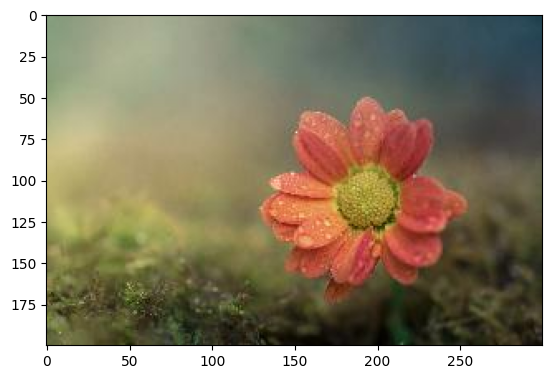

In [3]:
image = plt.imread("input.jpg")
plt.imshow(image)

##### Image Compression Using PCA

In [4]:
class pca_compression():
    '''
    This is the class that take the image input and gives the compresed image as output
    given the no of components using PCA
    '''
    def __init__(self,n) -> None:
        self.n_com = n

    def cov(self,x,y):
        '''
        return the covariance value between x,y
        '''
        x1 = x-np.mean(x)
        y1 = y-np.mean(y)
        res = np.sum(x1*y1)/(len(x1)-1)
        return res
    
    def convoluted_matrix(self,X):
        '''
        returns the covariance matrix as the output for the given input matrix
        '''
        n1 = len(X)
        res = np.zeros((n1,n1))
        for i in range(n1):
            for j in range(i,n1):
                res[i][j] = res[j][i] = self.cov(X[i],X[j])
        return res
    
    def normalize(self,n):
        '''
        returns the normalized input
        '''
        return (n - n.min())/(n.max() - n.min())
    
    def get_non_normalized_reconstrcted_img(self):
        return self.recon_non_norm
    
    def get_pca(self,X,n):
        '''
        returns the eigen values and the compresed matrix of the input matrix
        '''
        res1 = self.convoluted_matrix(X)
        eigval,eigvec = np.linalg.eig(res1)

        i = eigval.argsort()[::-1]
        eigval = eigval[i]
        eigvec = eigvec[:,i]
        
        res_arr = eigvec[:,:n]
        return X.T.dot(res_arr) , res_arr
    
    def get_compressed_image(self,image):
        '''
        returns the compressed image as output for given input
        '''
        res_image = []
        eigen_matrices = []
        
        #sending each matrix in image for pca
        for i in range(image.shape[-1]):
            res , eigen_mat = self.get_pca(image[:,:,i],self.n_com)
            res_image.append(res)
            eigen_matrices.append(eigen_mat)

        #recombining the compressed matrices
        res = np.transpose(np.array(res_image),(1,2,0))
        eigen_matrices = np.transpose(np.array(eigen_matrices),(1,2,0))
        self.eigen_mat = eigen_matrices
        return res

    def get_reconstructed_image(self,image):
        '''
        returns the reconstructed image as output for given compressed image
        '''
        try:
            ori_image = []
            ori_image2 = []

            #multiplying each matrix in input with eigen values
            for i in range(image.shape[-1]):
                res = image[:,:,i] @ self.eigen_mat[:,:,i].T
                ori_image2.append(res.T)
                res = self.normalize(res)
                ori_image.append(res.T)

            #reconstruncting the original image
            ori_image = np.transpose(np.array(ori_image),(1,2,0))
            ori_image2 = np.transpose(np.array(ori_image2),(1,2,0))
            self.recon_non_norm = ori_image2
            return ori_image
        except Exception as e:
            print(e)
    


Results of PCA

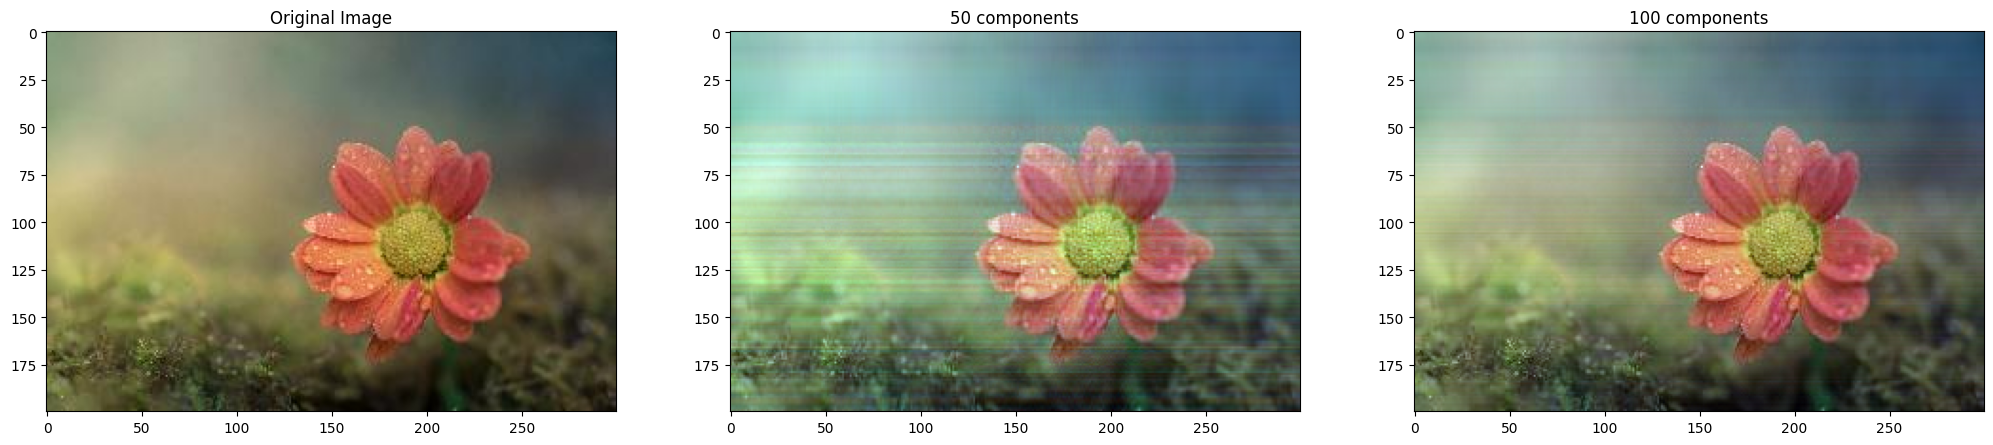

In [5]:
fig , a = plt.subplots(1,3,figsize=(25,25))
a[0].imshow(image)
a[0].set_title("Original Image")
j=1
for i in [50,100]:
    comp1 = pca_compression(i)
    
    #compressing image
    comp_image1 = comp1.get_compressed_image(image)

    #getting reconstructed imahe
    recon_image1 = comp1.get_reconstructed_image(comp_image1)
    recon_image1 = np.array(recon_image1,dtype=np.float32)

    a[j].imshow(recon_image1)
    a[j].set_title(f"{i} components")
    j += 1
plt.show()

##### Image Compression using SVD

In [6]:
class svd_compression():
    '''
    This is the class that take the image input and gives the compresed image as output
    given the no of components using SVD
    '''
    def __init__(self,n) -> None:
        self.n_com = n

    def normalize(self,n):
        '''
        returns the normalized input
        '''
        return (n - n.min())/(n.max() - n.min())
    
    def get_SVD(self,X,k):
        '''
        returns U,S,V of the input matrix using SVD
        '''
        U, S, Vt = np.linalg.svd(X)
        return U[:,:k],np.diag(S[:k]),Vt[:k, :]
    
    
    def get_compressed_image(self,image):
        '''
        returns the compressed image as output for given input
        '''
        res_image = []
        eigen_matrices = []

        #sending each matrix in image for svd
        for i in range(image.shape[-1]):
            u,s,v = self.get_SVD(image[:,:,i],self.n_com)
            res_image.append(u @ s)
            eigen_matrices.append(v)

        #recombining the compressed matrices
        res = np.transpose(np.array(res_image),(1,2,0))
        self.V = eigen_matrices
        return res
    
    def get_non_normalized_reconstrcted_img(self):
        return self.recon_non_norm

    def get_reconstructed_image(self,image):
        '''
        returns the reconstructed image as output for given compressed image
        '''
        try:
            ori_image = []
            ori_image2 = []

            #multiplying each matrix in input with corresponding matrix V
            for i in range(image.shape[-1]):
                res = image[:,:,i] @ self.V[i]
                ori_image2.append(res)
                res = self.normalize(res)
                ori_image.append(res)

            #reconstruncting the original image
            ori_image = np.transpose(np.array(ori_image),(1,2,0))
            ori_image2 = np.transpose(np.array(ori_image2),(1,2,0))
            self.recon_non_norm = ori_image2
            return ori_image
        except Exception as e:
            print(e)


Results of SVD

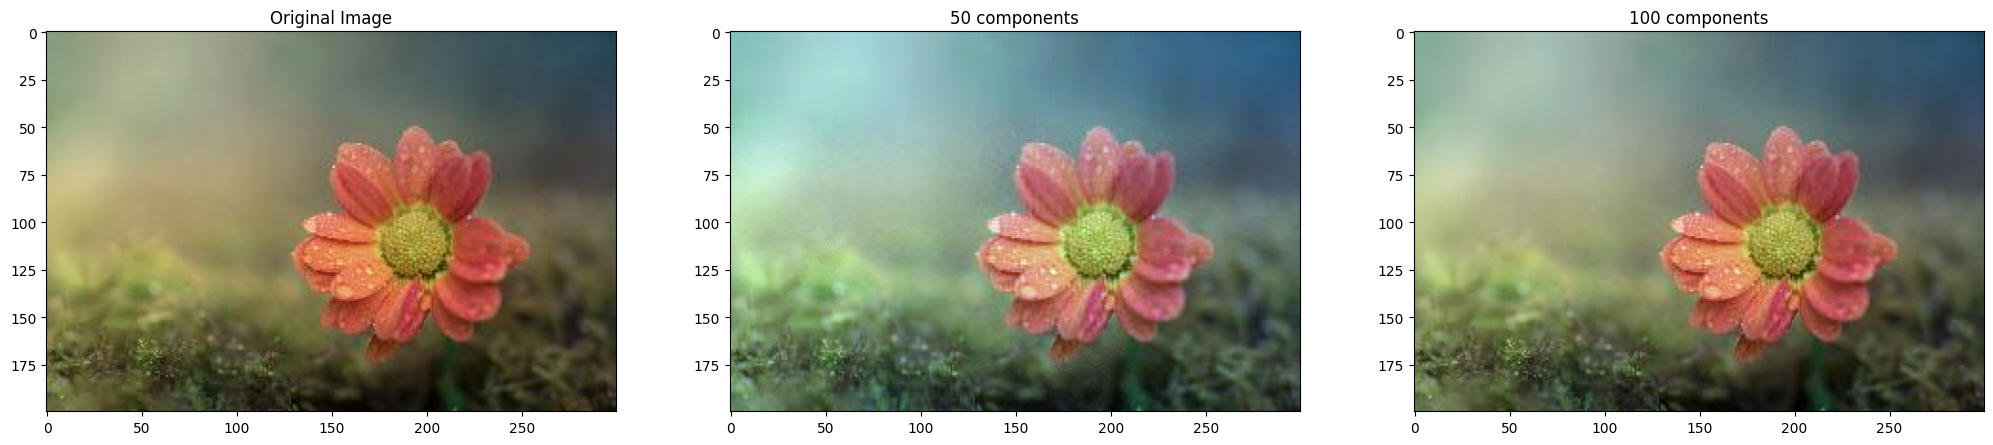

In [7]:
fig , a = plt.subplots(1,3,figsize=(25,25))
a[0].imshow(image)
a[0].set_title("Original Image")
j=1
for i in [50,100]:
    comp1 = svd_compression(i)

    #compressing image
    comp_image1 = comp1.get_compressed_image(image)

    #getting reconstructed imahe
    recon_image1 = comp1.get_reconstructed_image(comp_image1)
    recon_image1 = np.array(recon_image1,dtype=np.float32)
    
    a[j].imshow(recon_image1)
    a[j].set_title(f"{i} components")
    j += 1
plt.show()

##### Image compression using NMF

In [8]:
class nmf_compression():
    def __init__(self,n) -> None:
        self.n_com = n

    def normalize(self,n):
        '''
        returns the normalized input
        '''
        return (n - n.min())/(n.max() - n.min())
    
    def get_NMF(self,X,k):
        '''
        returns U,S,V of the input matrix using NMF
        '''
        model = sklearn.decomposition.NMF(k)
        W = model.fit_transform(X)
        H = model.components_
        return W,H

    
    def get_compressed_image(self,image):
        '''
        returns the compressed image as output for given input
        '''
        res_image = []
        H_matrices = []

        #sending each matrix in image for nmf
        for i in range(image.shape[-1]):
            w,h = self.get_NMF(image[:,:,i],self.n_com)
            res_image.append(w)
            H_matrices.append(h)

        #recombining the compressed matrices
        res = np.transpose(np.array(res_image),(1,2,0))
        self.h_mat = H_matrices
        return res
    
    def get_non_normalized_reconstrcted_img(self):
        return self.recon_non_norm

    def get_reconstructed_image(self,image):
        '''
        returns the reconstructed image as output for given compressed image
        '''
        try:
            ori_image = []
            ori_image2 = []

            #multiplying each matrix in input with corresponding matrix V
            for i in range(image.shape[-1]):
                res = image[:,:,i] @ self.h_mat[i]
                ori_image2.append(res)
                res = self.normalize(res)
                ori_image.append(res)

            #reconstruncting the original image
            ori_image = np.transpose(np.array(ori_image),(1,2,0))
            ori_image2 = np.transpose(np.array(ori_image2),(1,2,0))
            self.recon_non_norm = ori_image2
            return ori_image
        except Exception as e:
            print(e)


Results of NMF

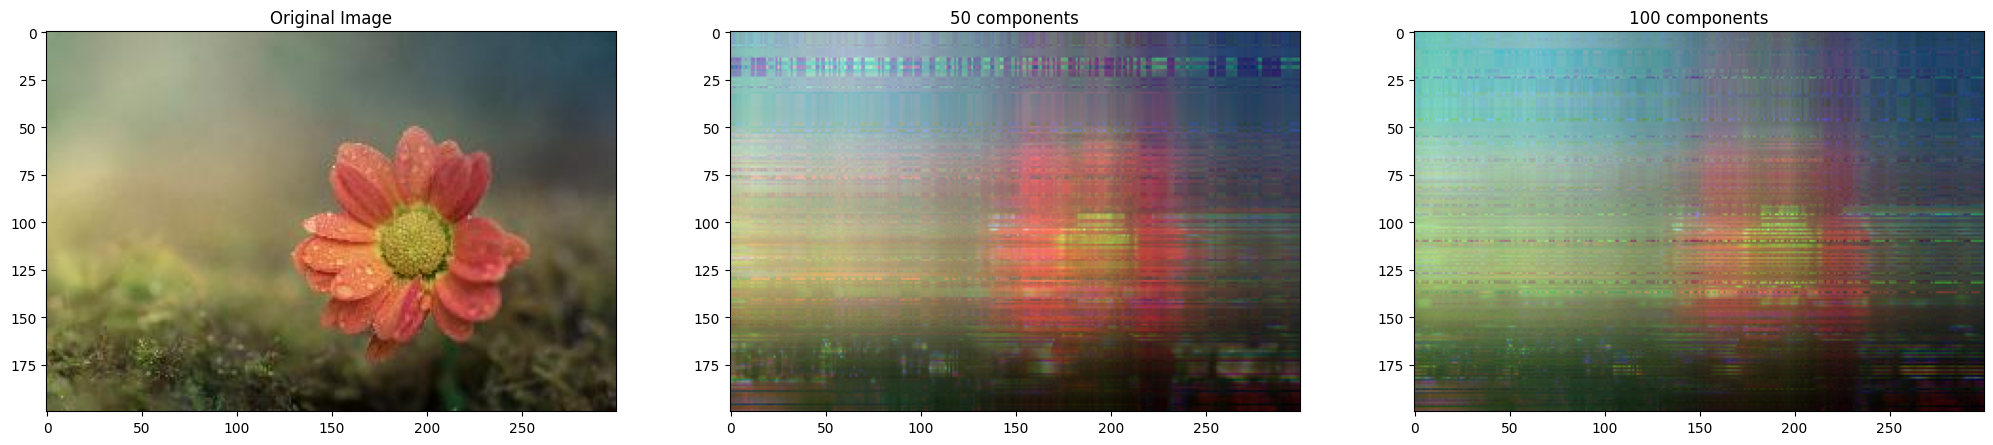

In [9]:
fig , a = plt.subplots(1,3,figsize=(25,25))
a[0].imshow(image)
a[0].set_title("Original Image")
j=1
for i in [50,100]:
    comp1 = nmf_compression(i)
    
    #compressing image
    comp_image1 = comp1.get_compressed_image(image)

    #getting reconstructed imahe
    recon_image1 = comp1.get_reconstructed_image(comp_image1)
    recon_image1 = np.array(recon_image1,dtype=np.float32)

    a[j].imshow(recon_image1)
    a[j].set_title(f"{i} components")
    j += 1
plt.show()

##### Comparision of Metrics for compression techniques

In [10]:
comp_factor1,comp_factor2,comp_factor3 = [],[],[]
mse_loss1,mse_loss2,mse_loss3 = [],[],[]
factors = [10,30,50,70,90]
for i in factors:
    #PCA
    comp1 = pca_compression(i)
    comp_image1 = comp1.get_compressed_image(image)
    recon_image1 = comp1.get_reconstructed_image(comp_image1)
    recon_image_non1 = comp1.get_non_normalized_reconstrcted_img()
    comp_factor1.append(compression_factor(image,recon_image_non1))
    mse_loss1.append(mse_loss(recon_image_non1,image))

    #SVD
    comp2 = svd_compression(i)
    comp_image2 = comp2.get_compressed_image(image)
    recon_image2 = comp2.get_reconstructed_image(comp_image2)
    recom_image_non2 = comp2.get_non_normalized_reconstrcted_img()
    comp_factor2.append(compression_factor(image,recom_image_non2))
    mse_loss2.append(mse_loss(image,recom_image_non2))


    #NMF
    comp3 = nmf_compression(i)
    comp_image3 = comp3.get_compressed_image(image)
    recon_image3 = comp3.get_reconstructed_image(comp_image3)
    recom_image_non3 = comp3.get_non_normalized_reconstrcted_img()
    comp_factor3.append(compression_factor(image,recom_image_non3))
    mse_loss3.append(mse_loss(image,recom_image_non3))

Plot of Compression Quality

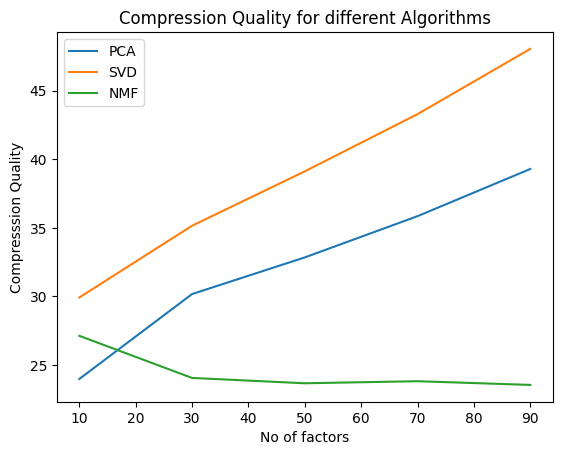

In [11]:
plt.plot(factors,comp_factor1,label="PCA")
plt.plot(factors,comp_factor2,label="SVD")
plt.plot(factors,comp_factor3,label="NMF")
plt.legend()
plt.title("Compression Quality for different Algorithms")
plt.xlabel('No of factors')
plt.ylabel('Compresssion Quality')
plt.show()

plot of mse loss

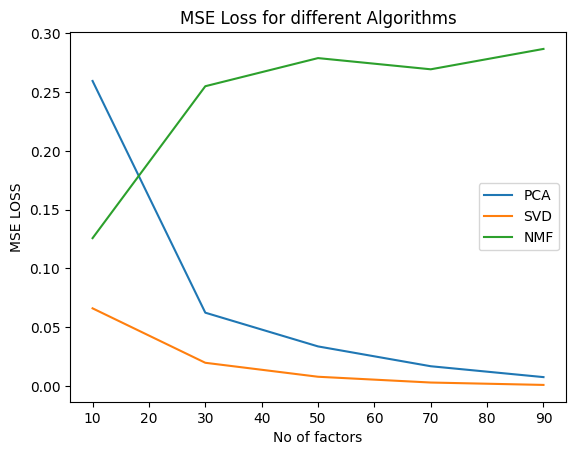

In [12]:
plt.plot(factors,np.array(mse_loss1)/1000,label="PCA")
plt.plot(factors,np.array(mse_loss2)/1000,label="SVD")
plt.plot(factors,np.array(mse_loss3)/1000,label="NMF")
plt.title("MSE Loss for different Algorithms")
plt.legend()
plt.xlabel('No of factors')
plt.ylabel('MSE LOSS')
plt.show()